<a href="https://www.kaggle.com/code/loananh/linear-regression?scriptVersionId=226941781" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#Prepare Python Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression

# Load Dataframe
data = pd.read_csv('/kaggle/input/hose-market/CafeF.HSX.Upto07.03.2025.csv')

# Rename column <DTYYYYMMDD> to Date
data.rename(columns={'<DTYYYYMMDD>': '<Date>'}, inplace=True)

# Convert <DTYYYYMMDD> from number to date format
data['<Date>'] = pd.to_datetime(data['<Date>'], format='%Y%m%d')

# Filter Stock Data for Analytics (SSI Stock in 10 years)
start_date = datetime.now()
end_date = datetime(start_date.year-10, start_date.month, start_date.day)
df = data[(data['<Ticker>']=='SSI') & (data['<Date>'] >= end_date) & (data['<Date>'] <= start_date)]

# Sort date and index in ascending
df = df.iloc[::-1]
df = df.reset_index(drop = True, inplace = False)

print(df.head())
print(df.tail())

  <Ticker>     <Date>  <Open>  <High>   <Low>  <Close>  <Volume>
0      SSI 2015-03-11  6.5013  6.5013  6.4154   6.4163   1280070
1      SSI 2015-03-12  6.4154  6.4440  6.3294   6.4163   1332560
2      SSI 2015-03-13  6.4440  6.4726  6.3867   6.3876    854900
3      SSI 2015-03-16  6.3867  6.4154  6.3008   6.3017   1281810
4      SSI 2015-03-17  6.3008  6.3867  6.3008   6.3590    927590
     <Ticker>     <Date>  <Open>  <High>  <Low>  <Close>  <Volume>
2492      SSI 2025-03-03   26.30   26.80  26.15    26.60  25645100
2493      SSI 2025-03-04   26.45   26.60  26.10    26.35  24072400
2494      SSI 2025-03-05   26.40   26.65  26.10    26.10  27564200
2495      SSI 2025-03-06   26.20   26.95  26.20    26.90  44988800
2496      SSI 2025-03-07   27.10   27.15  26.80    26.90  22896800


In [2]:
#Get the duration of data set
print("Starting date: ", df.iloc[0]['<Date>'])
print("Ending date: ", df.iloc[-1]['<Date>'])
print("Duration: ", df.iloc[-1]['<Date>'] - df.iloc[0]['<Date>'])

Starting date:  2015-03-11 00:00:00
Ending date:  2025-03-07 00:00:00
Duration:  3649 days 00:00:00


In [3]:
# Prepare data for linear regression
df['<Close>'] = df['<Close>'].astype(float)
df['Days'] = (df['<Date>'] - df['<Date>'].min()).dt.days
X = df[['Days']]
y = df['<Close>']

# Train the model
model = LinearRegression()
model.fit(X.values, y)

# Predict the next 10 days
future_days = np.array([df['Days'].max() + i for i in range(1, 11)]).reshape(-1, 1)
predictions = model.predict(future_days)

# Print predictions
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions, 1):
    print(f"Day {i}: {prediction}")

Predictions for the next 10 days:
Day 1: 25.574946722575724
Day 2: 25.58115766897225
Day 3: 25.587368615368774
Day 4: 25.593579561765303
Day 5: 25.599790508161828
Day 6: 25.606001454558353
Day 7: 25.612212400954878
Day 8: 25.618423347351406
Day 9: 25.62463429374793
Day 10: 25.630845240144456


In [4]:
# Calculate ROI (Return on Investment)
initial_price = df['<Close>'].iloc[-1]
final_price = predictions[-1]
roi = (final_price - initial_price) / initial_price * 100

# Test ROI for loss and profit
print(f"Initial Price: {initial_price}")
print(f"Final Predicted Price: {final_price}")
print(f"Return on Investment (ROI) over the next 10 days: {roi:.2f}%")

Initial Price: 26.9
Final Predicted Price: 25.630845240144456
Return on Investment (ROI) over the next 10 days: -4.72%


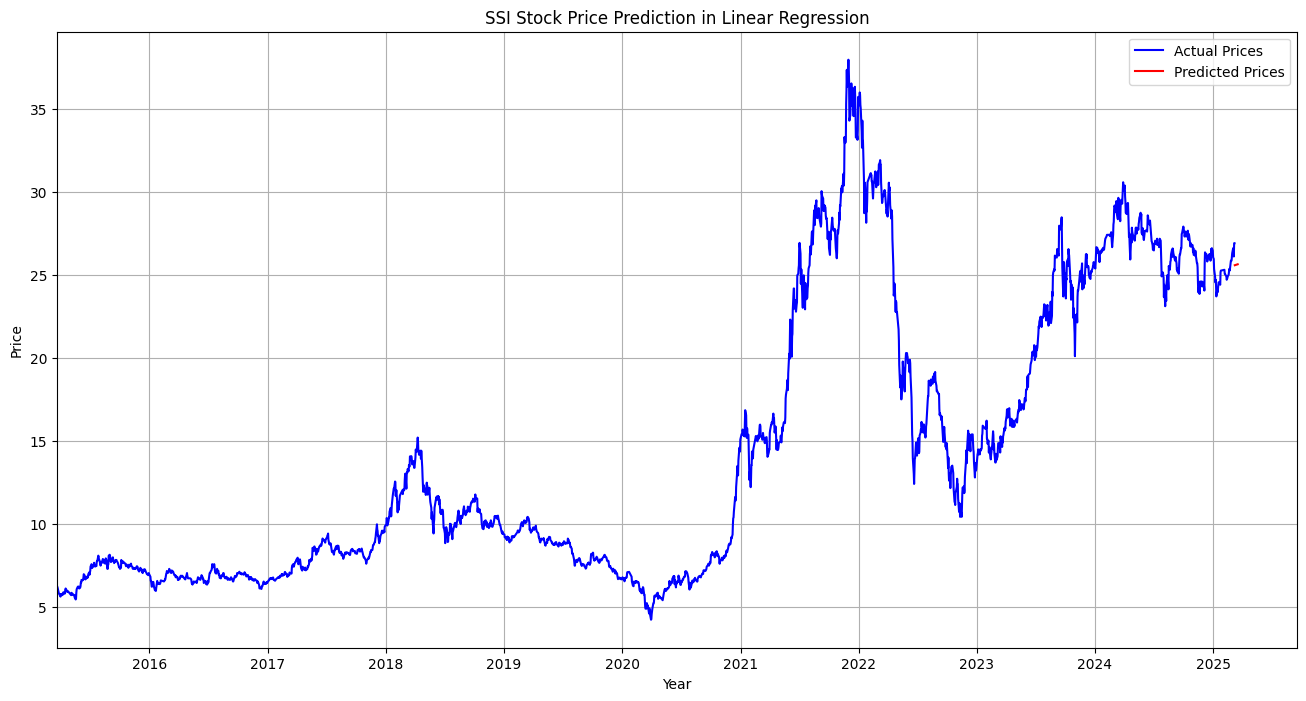

In [5]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(df['<Date>'], df['<Close>'], label='Actual Prices', color='blue')
future_dates = [df['<Date>'].max() + pd.Timedelta(days=i) for i in range(1, 11)]
plt.plot(future_dates, predictions, label='Predicted Prices', color='red')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('SSI Stock Price Prediction in Linear Regression')
plt.legend()
plt.grid(True)

# Set x-axis limits to show the whole closing stock price with prediction
plt.xlim(df['<Date>'].min() + pd.Timedelta(days=10))
plt.show()